In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_train_trans = pd.read_csv('../input/train_transaction.csv')
df_train_identity = pd.read_csv('../input/train_identity.csv')

df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')

print(df_train.shape)
del df_train_trans, df_train_identity

(590540, 434)


In [4]:
df_train = reduce_mem_usage(df_train)    

start_mem Memory usage of df_train: 2513.97 MB
Mem. usage decreased to 1204.57 Mb (52.1% reduction)


In [5]:
# Label encoding for categorical features
for col in df_train.select_dtypes(include='object').columns:
    lbl = LabelEncoder()
        
    encoded_values = lbl.fit_transform(df_train[col]) 
        
    #Replace the NaN (which becomes -1 after LabelEncoding) with -999
    encoded_values[df_train[col].isnull()] = -999
        
    # Step 5: Assign the encoded values back to the column
    df_train[col] = encoded_values

df_train.fillna(-999, inplace=True)
percent_missing = (df_train == -999).mean() * 100

# Identify columns where more than 50% of the values are missing
cols_to_drop = percent_missing[percent_missing > 50].index

cols_to_keep = ['R_emaildomain', 'DeviceInfo', 'DeviceType', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'dist1', 'dist2', 'id_31', 'id_30', 'M5', 'M7', 'M8', 'M9']
cols_to_drop = cols_to_drop.drop(cols_to_keep, errors='ignore') # Exclude 'R_emaildomain' from dropping

# Drop these columns
df_train_cleaned = df_train.drop(columns=cols_to_drop)

remove_columns = ['M4']
# Drop these columns
df_train_cleaned = df_train_cleaned.drop(columns=remove_columns)

# Display the cleaned dataframe
print(f"Columns removed: {cols_to_drop}")
print(f"Shape of the cleaned dataframe: {df_train_cleaned.shape}")

Columns removed: Index(['V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146',
       'V147',
       ...
       'id_27', 'id_28', 'id_29', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38'],
      dtype='object', length=195)
Shape of the cleaned dataframe: (590540, 238)


In [6]:
df_train_cleaned = df_train_cleaned.drop('TransactionID', axis=1)

# Select only numerical columns
X_train = df_train_cleaned.drop(columns=['isFraud'])
y_train = df_train_cleaned['isFraud']

# Train-test split (80% train, 20% validation)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# toto dole bez tuningu a dosahuje 0.76 f1 score

In [10]:
model = xgb.XGBClassifier(
    objective= "binary:logistic",
    n_estimators=600,
    max_depth=8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    learning_rate=0.1,
    random_state=4,
    colsample_bytree=0.8,
    gamma=0.1,
    subsample=0.8,
    verbosity=0
)
model.fit(X_train_final, y_train_final)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=600,
              n_jobs=None, num_parallel_tree=None, ...)

Training Performance:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    455902
           1       0.99      0.84      0.91     16530

    accuracy                           0.99    472432
   macro avg       0.99      0.92      0.95    472432
weighted avg       0.99      0.99      0.99    472432

Validation Performance:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.95      0.63      0.76      4133

    accuracy                           0.99    118108
   macro avg       0.97      0.82      0.88    118108
weighted avg       0.99      0.99      0.98    118108



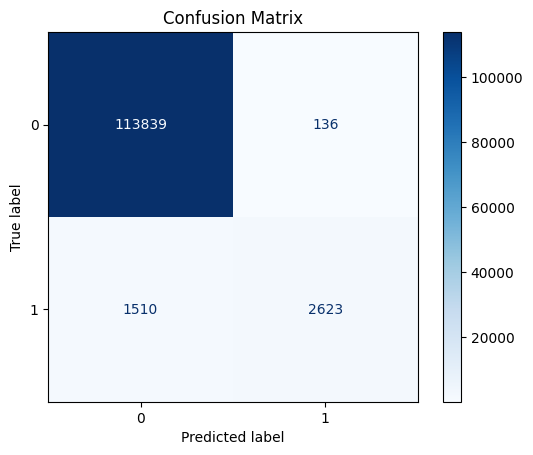

In [11]:
# Predictions on training data
y_train_pred = model.predict(X_train_final)
print("Training Performance:\n", classification_report(y_train_final, y_train_pred))

# Predictions on validation data
y_val_pred = model.predict(X_val)
print("Validation Performance:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# this down is good

In [8]:
model = xgb.XGBClassifier(
    objective= "binary:logistic",
    n_estimators=400,
    max_depth=8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    learning_rate=0.1,
    random_state=4,
    colsample_bytree=0.8,
    scale_pos_weight=5,
    gamma=0.1,
    subsample=0.8,
    early_stopping_rounds=10,  # Stop after 30 rounds with no improvement
    eval_metric="logloss",
    verbosity=0
)
model.fit(X_train_final, y_train_final, eval_set=[(X_val, y_val)])

[0]	validation_0-logloss:0.25443
[1]	validation_0-logloss:0.24016
[2]	validation_0-logloss:0.22818
[3]	validation_0-logloss:0.21720
[4]	validation_0-logloss:0.20784
[5]	validation_0-logloss:0.19938
[6]	validation_0-logloss:0.19161
[7]	validation_0-logloss:0.18495
[8]	validation_0-logloss:0.17866
[9]	validation_0-logloss:0.17333
[10]	validation_0-logloss:0.16810
[11]	validation_0-logloss:0.16327
[12]	validation_0-logloss:0.15932
[13]	validation_0-logloss:0.15569
[14]	validation_0-logloss:0.15229
[15]	validation_0-logloss:0.14905
[16]	validation_0-logloss:0.14607
[17]	validation_0-logloss:0.14334
[18]	validation_0-logloss:0.14071
[19]	validation_0-logloss:0.13838
[20]	validation_0-logloss:0.13631
[21]	validation_0-logloss:0.13456
[22]	validation_0-logloss:0.13260
[23]	validation_0-logloss:0.13086
[24]	validation_0-logloss:0.12903
[25]	validation_0-logloss:0.12747
[26]	validation_0-logloss:0.12636
[27]	validation_0-logloss:0.12528
[28]	validation_0-logloss:0.12412
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

Training Performance:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    455902
           1       0.92      0.90      0.91     16530

    accuracy                           0.99    472432
   macro avg       0.96      0.95      0.95    472432
weighted avg       0.99      0.99      0.99    472432

Validation Performance:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.84      0.72      0.78      4133

    accuracy                           0.99    118108
   macro avg       0.92      0.86      0.88    118108
weighted avg       0.98      0.99      0.98    118108



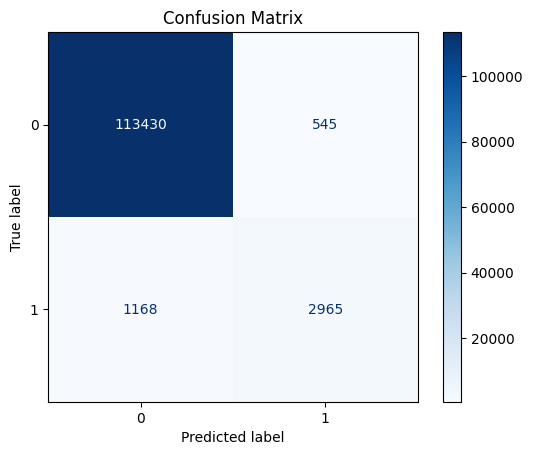

In [9]:
# Predictions on training data
y_train_pred = model.predict(X_train_final)
print("Training Performance:\n", classification_report(y_train_final, y_train_pred))

# Predictions on validation data
y_val_pred = model.predict(X_val)
print("Validation Performance:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()